In [1]:
import re

import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
stop_words = set(stopwords.words('english'))
ignored_stopwords = ['not', 'down', 'before', 'over', 'more', 'off']
for word in ignored_stopwords:
    stop_words.remove(word)

In [3]:
from gensim.models.fasttext import FastText
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/savidude/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/savidude/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
def process_text(document):
    # Remove extra white space from text
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Remove all the special characters from text
    document = re.sub(r'\W', ' ', str(document))
    # Remove all single characters from text
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Converting to Lowercase
    document = document.lower()
    # Word tokenization
    tokens = document.split()
    # Lemmatization using NLTK
    lemma_txt = [stemmer.lemmatize(word) for word in tokens]
    # Remove stop words
    lemma_no_stop_txt = [word for word in lemma_txt if word not in stop_words]
    # Drop words
    tokens = [word for word in tokens if len(word) > 3]
    clean_txt = ' '.join(lemma_no_stop_txt)
    return clean_txt

In [5]:
reviews = pd.read_csv("data/derived/restaurant_reviews_textblob.csv", sep="\t")

In [6]:
corpus = []
for i, review in reviews.iterrows():
    corpus.append(review['Review'])

clean_corpus = [process_text(sentence) for sentence in corpus if sentence.strip() != '']

In [7]:
word_tokenizer = nltk.WordPunctTokenizer()
word_tokens = [word_tokenizer.tokenize(sent) for sent in clean_corpus]

In [8]:
embedding_size = 300
window_size = 5
min_word = 5
down_sampling = 1e-2

fast_Text_model = FastText(word_tokens,
                           # size=embedding_size,
                           window=window_size,
                           min_count=min_word,
                           sample=down_sampling,
                           workers=4,
                           sg=1)

In [9]:
fast_Text_model.wv['chicken']

array([-0.00352345, -0.01155018,  0.1105684 ,  0.00524501,  0.1549084 ,
        0.1522243 ,  0.07765193,  0.50587225, -0.02388257,  0.00738788,
       -0.05970728,  0.06126837, -0.1832731 ,  0.25148442,  0.13091254,
       -0.11334187,  0.07216428,  0.01202735, -0.18291245, -0.13479486,
       -0.07008764,  0.17648198, -0.02151688, -0.19936295,  0.02323141,
       -0.02389483,  0.02976048, -0.00090806, -0.04175892, -0.04774924,
       -0.20081669, -0.17050715,  0.25315836, -0.2965657 , -0.10143424,
        0.3213642 ,  0.09857495,  0.10359335,  0.05491275,  0.06558191,
       -0.10708011, -0.12474342,  0.08852992, -0.18807893, -0.21038273,
        0.08212434, -0.1212093 ,  0.14439829, -0.15580836,  0.23318994,
        0.07215071,  0.00200366, -0.03794201,  0.01790297,  0.04651084,
       -0.26052296, -0.01485161,  0.0535107 , -0.03502288,  0.17661868,
        0.0824657 , -0.1165853 , -0.19256638,  0.2263536 ,  0.12352968,
        0.16075869,  0.01123236,  0.03594051,  0.06896784,  0.08

In [10]:
fast_Text_model.wv['chicken'].shape

(100,)

create an empty dataframe to save vectors for each sentences

In [11]:
word_vectors = pd.DataFrame()
for doc in pd.Series(clean_corpus):
    # create another empty dataframe to save vector values for each word
    temp = pd.DataFrame()
    # looping through each word of a single document and spliting through space
    for word in doc.split(' '):
        if word not in stop_words:
            try:
                embedding = fast_Text_model.wv[word]
                temp = temp.append(pd.Series(embedding), ignore_index = True)
            except:
                pass
            
    word_vectors = word_vectors.append(temp.mean(), ignore_index = True) 
    
word_vectors.shape

/tmp/ipykernel_5985/238144177.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(pd.Series(embedding), ignore_index = True)
/tmp/ipykernel_5985/238144177.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  word_vectors = word_vectors.append(temp.mean(), ignore_index = True)


(1000, 100)

In [12]:
train_x, test_x, train_y, test_y = train_test_split(word_vectors,
                                                   reviews['Liked'],
                                                   test_size = 0.3,
                                                   random_state = 1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((700, 100), (700,), (300, 100), (300,))

In [14]:
rf = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', max_depth=50)
model = rf.fit(train_x, train_y)
y_pred = model.predict(test_x)

In [15]:
cm = confusion_matrix(y_pred, test_y)
cm

array([[88, 54],
       [73, 85]])

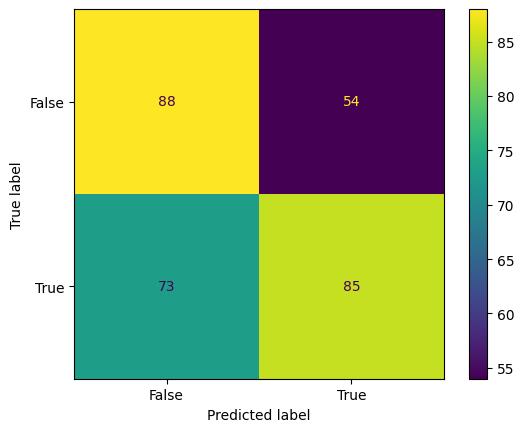

In [16]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()

In [17]:
pd.DataFrame(classification_report(test_y, y_pred, output_dict=True)).T 

,precision,recall,f1-score,support
0,0.619718,0.546584,0.580858,161.000000
1,0.537975,0.611511,0.572391,139.000000
accuracy,0.576667,0.576667,0.576667,0.576667
macro avg,0.578846,0.579047,0.576624,300.000000
weighted avg,0.581844,0.576667,0.576935,300.000000
